In [34]:
import time
import os
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches
import numpy as np
import tensorflow as tf


import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from keras import layers, losses
from keras.models import Sequential
from sklearn import metrics
from tqdm import tqdm
from keras.optimizers import Adam
from keras.layers import InputLayer, LSTM, Dense, RepeatVector, TimeDistributed, LayerNormalization, Dropout
from keras.models import Model

In [2]:
try:
    # enable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type == 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

## Data Loading

In [3]:
# Set the directories
DATA_DIR_SLOW = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaSlow.npy"
DATA_DIR_NORMAL = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaNormal.npy"
DATA_DIR_C_NAMES = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaColumnNames.npy"

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [4]:
# Load the files
data_normal = np.load(DATA_DIR_NORMAL)
data_slow = np.load(DATA_DIR_SLOW)
column_names = np.load(DATA_DIR_C_NAMES)

In [5]:
# Check the column names
print(column_names)

['action' 'machine_nameKuka Robot_apparent_power'
 'machine_nameKuka Robot_current' 'machine_nameKuka Robot_frequency'
 'machine_nameKuka Robot_phase_angle' 'machine_nameKuka Robot_power'
 'machine_nameKuka Robot_power_factor'
 'machine_nameKuka Robot_reactive_power' 'machine_nameKuka Robot_voltage'
 'sensor_id1_AccX' 'sensor_id1_AccY' 'sensor_id1_AccZ' 'sensor_id1_GyroX'
 'sensor_id1_GyroY' 'sensor_id1_GyroZ' 'sensor_id1_q1' 'sensor_id1_q2'
 'sensor_id1_q3' 'sensor_id1_q4' 'sensor_id1_temp' 'sensor_id2_AccX'
 'sensor_id2_AccY' 'sensor_id2_AccZ' 'sensor_id2_GyroX' 'sensor_id2_GyroY'
 'sensor_id2_GyroZ' 'sensor_id2_q1' 'sensor_id2_q2' 'sensor_id2_q3'
 'sensor_id2_q4' 'sensor_id2_temp' 'sensor_id3_AccX' 'sensor_id3_AccY'
 'sensor_id3_AccZ' 'sensor_id3_GyroX' 'sensor_id3_GyroY'
 'sensor_id3_GyroZ' 'sensor_id3_q1' 'sensor_id3_q2' 'sensor_id3_q3'
 'sensor_id3_q4' 'sensor_id3_temp' 'sensor_id4_AccX' 'sensor_id4_AccY'
 'sensor_id4_AccZ' 'sensor_id4_GyroX' 'sensor_id4_GyroY'
 'sensor_id4_GyroZ

## Data Setup

In [35]:
# prepare labels and separate them from data-slow
label_slow = data_slow[:,-1:] - 1
data_slow = data_slow[:,:-1]

In [7]:
# Find the features that have less variable values than given threshold
threshold = 31

unique = {}
for i in range(data_normal.shape[1]):
    classes = np.unique(data_normal[:,i])
    if len(classes) < threshold:
        unique[i] = [len(classes) , classes]
print(unique, len(unique))
delete_list = []
for i in range(data_normal.shape[1]):
    if i not in unique.keys():
        delete_list.append(False)
    else:
        delete_list.append(True)

{3: [5, array([49.902534, 49.951218, 50.      , 50.048878, 50.097847])], 30: [1, array([144.12])], 41: [2, array([120.3 , 144.12])], 52: [3, array([-175.86,    9.59,  144.12])], 63: [1, array([144.12])], 74: [1, array([180.24])], 85: [1, array([180.24])]} 7


In [8]:
# Take the features less variable than given threshold
data_normal_dr = np.delete(data_normal, delete_list, axis=1)
data_slow_dr = np.delete(data_slow, delete_list, axis=1)
print(f"Shape of slow data after basic feature selection: {data_slow_dr.shape} \nFor normal data: {data_normal_dr.shape}")

Shape of slow data after basic feature selection: (41538, 79) 
For normal data: (233792, 79)


In [9]:
# Normalization train on train set transform both
scaler = preprocessing.StandardScaler().fit(data_normal_dr)
data_train_scaled = scaler.transform(data_normal_dr)
data_test_scaled = scaler.transform(data_slow_dr)

In [10]:
#windows of 48 with stride 1
width_window = 48
data_train_all = np.array([data_train_scaled[i:i+width_window,:] for i in range(0, len(data_train_scaled)-width_window)])
data_test_all = np.array([data_test_scaled[i:i+width_window,:] for i in range(0, len(data_test_scaled)-width_window)])
print(f"train data shape: {data_train_all.shape} \n test data shape: {data_test_all.shape} ")

train data shape: (233744, 48, 79) 
 test data shape: (41490, 48, 79) 


In [11]:
# Shuffle the data
mix_data = True
seed = 0
if mix_data:
    data_train_all = tf.random.shuffle(data_train_all)
print(f"train data shape: {data_train_all.shape} \n")

train data shape: (233744, 48, 79) 



In [148]:
# First 60 percent for training, 20 percent for validation between 60-80, 20 percent for test from 80-100
percentage_train = 0.6
percentage_test = 1.
validation = [0.60, 0.80]
test = 0.80

# take part of data to gather results faster
data_train = data_train_all[0:int(percentage_train*data_train_all.shape[0]),:,:]
data_test = data_test_all[0:int(percentage_test*data_test_all.shape[0]),:,:]

# mixed test data 50-50
data_test_mixed = np.zeros((2*data_test.shape[0], data_test.shape[1], data_test.shape[2]))
data_test_mixed[0:int(data_test.shape[0]),:,:] += data_test
data_test_mixed[int(data_test.shape[0]):,:,:] += data_train_all[int(test*data_train_all.shape[0]): int(test*data_train_all.shape[0])+data_test.shape[0],:,:]

# set labels
label_test = label_slow[0:data_test.shape[0]]
label_test_mixed = np.zeros((data_test_mixed.shape[0], 1))
label_test_mixed[0:label_test.shape[0]] += label_test

# Validation data
data_validation = data_train_all[int(validation[0]*data_train_all.shape[0]): int(validation[1]*data_train_all.shape[0]),:,:]


print(f"train data shape: {data_train.shape} \ntest data shape: {data_test.shape} \nlabel shape: {label_test.shape} \n\ntest data prepared: {data_test_mixed.shape} \nlabel prepared: {label_test_mixed.shape} \n\ndata validation: {data_validation.shape}")

train data shape: (140246, 48, 79) 
test data shape: (41490, 48, 79) 
label shape: (41490, 1) 

test data prepared: (82980, 48, 79) 
label prepared: (82980, 1) 

data validation: (46749, 48, 79)


## Model

In [149]:
# set these variables before model creation

latent_size = 10
input_shape = data_train.shape[1:]
n_features = data_train.shape[2]
width_window = 48
dropout = False
layer_norm = True

In [150]:
# Autoencoder class
class Autoencoder(Model):
  def __init__(self, encoder, decoder, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = encoder
    self.decoder = decoder

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [183]:
# Encoder, Decoder, Discriminator functions

def build_model_enc():
    model = Sequential()
    model.add(LSTM(latent_size*16, activation='relu', input_shape=input_shape, return_sequences=True, recurrent_initializer='random_normal'))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*8, activation='relu', return_sequences=True, recurrent_initializer='random_normal'))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*4, activation='relu', return_sequences=True, recurrent_initializer='random_normal'))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*2, activation='relu', return_sequences=True, recurrent_initializer='random_normal'))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size, activation='relu', return_sequences=False, recurrent_initializer='random_normal'))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(RepeatVector(width_window))
    return model

def build_model_dec():
    model = Sequential()

    model.add(LSTM(latent_size, activation='relu', return_sequences=True, recurrent_initializer='random_normal'))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*2, activation='relu', return_sequences=True, recurrent_initializer='random_normal'))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*4, activation='relu', return_sequences=True, recurrent_initializer='random_normal'))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*8, activation='relu', return_sequences=True, recurrent_initializer='random_normal'))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*16, activation='relu', return_sequences=True, recurrent_initializer='random_normal'))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(units=n_features)))
    return model

def build_model_disc():
    model = Sequential()
    #model.add(layers.Dense(256, activation="relu", input_shape=(width_window, latent_size)))
    model.add(layers.Dense(64, activation="relu", input_shape=(width_window, latent_size)))
    model.add(layers.Dense(64, activation="relu"))
    #model.add(layers.Dense(16, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))
    return model

# To be sure model have the ability to reconstruct timeseries

In [121]:
model_enc = build_model_enc()
model_dec = build_model_dec()

model = Sequential()
model.add(model_enc)
model.add(model_dec)

learning_rate = 1e-4
optimizer = Adam(learning_rate=learning_rate)

tf.debugging.set_log_device_placement(True)
try:
    with tf.device('/GPU'):
        data_train = tf.convert_to_tensor(data_train, dtype=tf.float32)
        model = model
        model.compile(optimizer=optimizer, loss='mse')
        model.summary()
except RuntimeError as e:
    print(e)
history = model.fit(data_train, data_train, epochs=20, batch_size=128,validation_data=(data_validation, data_validation), shuffle=False)

ValueError: Tensor conversion requested dtype float32 for Tensor with dtype float64: <tf.Tensor: shape=(11687, 48, 79), dtype=float64, numpy=
array([[[-0.73499313, -1.00380422, -0.39113503, ...,  1.40474992,
         -1.74302682, -2.0413064 ],
        [-0.73499313, -1.00380422, -0.39113503, ...,  1.36479354,
         -1.71380519, -1.87681695],
        [-0.73499313, -1.00380422, -0.39113503, ...,  1.33398993,
         -1.69002883, -1.756147  ],
        ...,
        [ 1.24841329, -1.07813686, -1.74705088, ...,  1.59781629,
         -1.71359543, -1.87355293],
        [ 1.24841329, -1.07813686, -1.74705088, ...,  1.64577327,
         -1.74054641, -2.04049104],
        [ 1.24841329, -1.07813686, -1.74705088, ...,  1.68896558,
         -1.7646524 , -2.21175533]],

       [[-1.10688184, -0.87311917, -0.46282991, ...,  0.5552184 ,
         -0.77988632,  0.40447976],
        [-1.10688184, -0.87311917, -0.46282991, ...,  0.55998728,
         -0.77976735,  0.40506833],
        [-1.10688184, -0.87311917, -0.46282991, ...,  0.56492813,
         -0.77964286,  0.40561472],
        ...,
        [-1.10688184, -1.29653436, -1.82542974, ...,  1.21809774,
         -1.39932228, -0.68581493],
        [-1.10688184, -1.29653436, -1.82542974, ...,  1.21409246,
         -1.39943245, -0.6857382 ],
        [-1.10688184, -1.29653436, -1.82542974, ...,  1.2101352 ,
         -1.39960132, -0.68582054]],

       [[ 0.00878428, -0.27886607, -0.66571811, ...,  0.09242447,
          0.13962157,  0.81178015],
        [ 0.00878428, -0.27886607, -0.66571811, ...,  0.0831142 ,
          0.13902194,  0.8123416 ],
        [ 0.00878428, -0.27886607, -0.66571811, ...,  0.0693364 ,
          0.13934735,  0.81295776],
        ...,
        [ 0.00878428,  2.51989511,  1.89302654, ..., -0.94613568,
          0.87622053,  0.3371292 ],
        [ 0.00878428,  2.51989511,  1.89302654, ..., -0.93292628,
          0.87676433,  0.33724354],
        [ 0.00878428, -0.95365788, -0.43390725, ..., -0.92079749,
          0.87725084,  0.33731322]],

       ...,

       [[-0.48706733,  0.98523886,  0.13699647, ...,  0.4209195 ,
         -0.72006186,  0.43617792],
        [-0.48706733,  0.98523886,  0.13699647, ...,  0.43097375,
         -0.72018103,  0.43861402],
        [-0.48706733, -0.27528625, -0.14449838, ...,  0.44066876,
         -0.72024664,  0.44090077],
        ...,
        [-0.36310443,  0.84442736,  1.91792059, ...,  2.02785094,
         -1.76921654, -2.37955794],
        [-0.36310443,  0.84442736,  1.91792059, ...,  1.9960238 ,
         -1.77095204, -2.37957511],
        [-0.36310443,  0.84442736,  1.91792059, ...,  1.96567765,
         -1.77258829, -2.3797583 ]],

       [[-0.61103023, -0.78327215, -1.03243849, ..., -0.9594907 ,
          1.07877348,  0.06126155],
        [-0.61103023, -0.78327215, -1.03243849, ..., -0.95052067,
          1.07831484,  0.06250598],
        [-0.61103023, -0.78327215, -1.03243849, ..., -0.9437009 ,
          1.07737397,  0.06440515],
        ...,
        [-0.61103023, -0.9123147 , -0.51531245, ..., -1.40785162,
          1.54422291, -0.99791187],
        [-0.61103023, -0.9123147 , -0.51531245, ..., -1.39969384,
          1.54455607, -0.99822492],
        [-0.61103023, -0.9123147 , -0.51531245, ..., -1.39153278,
          1.54488627, -0.99853799]],

       [[ 1.37237619, -0.8772254 ,  0.18860038, ...,  1.74101607,
         -1.25325765, -0.38812622],
        [ 1.37237619, -0.8772254 ,  0.18860038, ...,  1.88659448,
         -1.34388373, -0.61541056],
        [ 1.37237619, -0.8772254 ,  0.18860038, ...,  2.00552855,
         -1.42467669, -0.84806174],
        ...,
        [ 1.37237619,  0.2933909 ,  1.10062753, ...,  0.81935594,
         -1.09820698, -0.04102632],
        [ 1.37237619,  0.2933909 ,  1.10062753, ...,  0.8239742 ,
         -1.09809283, -0.04017102],
        [ 1.37237619,  0.2933909 ,  1.10062753, ...,  0.82874573,
         -1.097974  , -0.03941945]]])>

In [183]:
p_train = model.predict(data_train)
difference_train = np.abs(p_train - data_train)
print(f"mean: {np.mean(difference_train)}")


p_test = model.predict(data_test)
difference_test = np.abs(p_test - data_test)
print(f"mean: {np.mean(difference_test)}")

731/731 [==============================] - 20s 27ms/step
mean: 0.5792578458786011
130/130 [==============================] - 4s 27ms/step
mean: 0.691194786464506


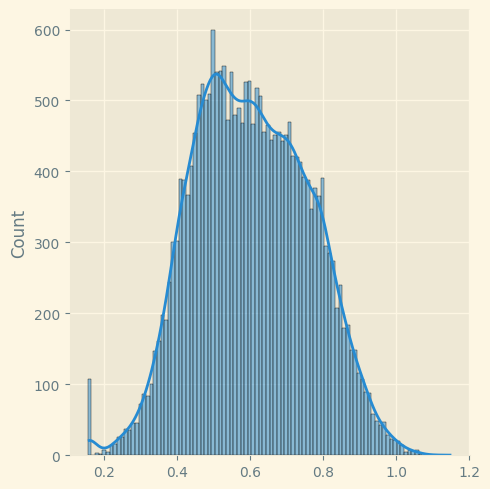

In [184]:
cost_train = np.mean(np.abs(p_train - data_train), axis=1)
sns.displot(cost_train[:,32], bins=100, kde=True)

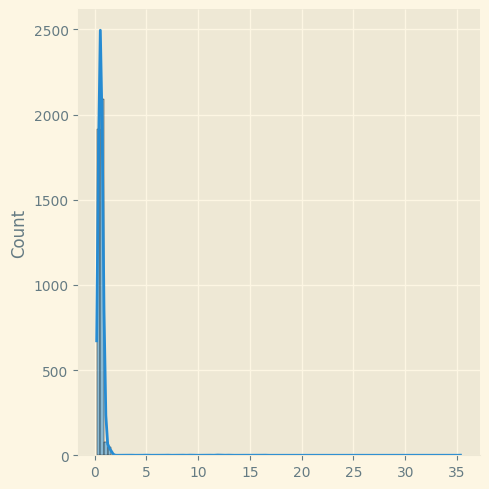

In [185]:
cost_test = np.mean(np.abs(p_test - data_test), axis=1)
sns.displot(cost_test[:,32], bins=100, kde=True)

260/260 [==============================] - 7s 28ms/step
mean: 0.6428241302673501


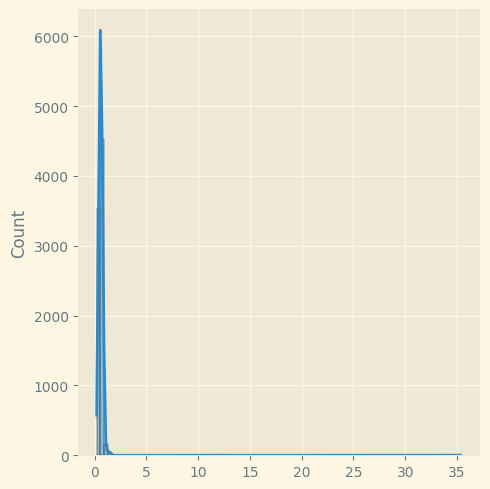

In [186]:
# Prepared test data
p_test_mixed = model.predict(data_test_mixed)

difference_test_mixed = np.abs(p_test_mixed - data_test_mixed)
print(f"mean: {np.mean(difference_test_mixed)}")

cost_test_mixed = np.mean(np.abs(p_test_mixed - data_test_mixed), axis=1)
sns.displot(cost_test_mixed[:,32], bins=100, kde=True)

In [187]:
# For model predictions
scores = np.mean(cost_test_mixed, axis=1)
targets = label_test_mixed

In [58]:
result = evaluate(scores, targets, k=50)

mean_f1_wo_pa = np.mean(result["f1_scores"])
mean_f1_w_pa = np.mean(result["pa_f1_scores"])
print(f"mean F1 score without PA: {mean_f1_wo_pa} \nmean F1 score with PA: {mean_f1_w_pa}")

100%|██████████| 829/829 [00:22<00:00, 36.80it/s]

mean F1 score without PA: 0.5529229144230015 
mean F1 score with PA: 0.5569327145159674


In [189]:
result

{'best_f1_wo_pa': 0.6948401771818508,
 'f1_scores': array([6.66666667e-01, 6.66720231e-01, 6.66613098e-01, ...,
        9.63623223e-04, 4.81927711e-04, 0.00000000e+00]),
 'best_precision_wo_pa': 0.6902949571836346,
 'best_recall_wo_pa': 0.6994456495541094,
 'prauc_wo_pa': 0.820171146070078,
 'auc_wo_pa': 0.7565672086668442,
 'raw_f1_w_pa': 0.6666666666666666,
 'raw_precision_w_pa': 0.5,
 'raw_recall_w_pa': 1.0,
 'best_f1_w_pa': 0.6667202313996465,
 'best_f1_th_w_pa': 0.6176282568694217,
 'best_precision_w_pa': 0.5000602627455707,
 'best_recall_w_pa': 1.0,
 'pa_f1_scores': array([0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
        0.6666

## Adversarial Autoencoder - Build Models & Create loss functions

In [184]:
# build functions for models

def build_models():
    model_enc = build_model_enc()
    model_dec = build_model_dec()
    model_disc = build_model_disc()

    model_ae = Autoencoder(model_enc, model_dec, latent_size)
    model_ae.build(input_shape=(None, input_shape[0], input_shape[1]))

    return model_disc, model_ae

def build_aae():
    model_disc, model_ae = build_models()

    ae_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_ae)
    dc_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_disc)
    gen_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_gen)

    try:
        with tf.device('/GPU'):
            #data_train = tf.convert_to_tensor(data_train, dtype=tf.int32)

            # discriminator
            model_disc = model_disc
            model_disc.compile(optimizer=dc_optimizer, loss=discriminator_loss)
            model_disc.summary()

            # discriminator encoder pipe (generator)
            # model_gen = model_gen
            # model_gen.compile(optimizer=gen_optimizer, loss=generator_loss)
            # model_gen.summary()

            # auto encoder
            model_ae = model_ae
            model_ae.compile(optimizer=ae_optimizer, loss=autoencoder_loss)
            model_ae.summary()
    except RuntimeError as e:
        print(e)
    return model_disc, model_ae , ae_optimizer, dc_optimizer, gen_optimizer

In [185]:
# Loss functions for autoencoder, discriminator and generator

def autoencoder_loss(inputs, reconstruction, loss_weight):
    return loss_weight * mse(inputs, reconstruction)


def discriminator_loss(real_output, fake_output, loss_weight):
    loss_real = cross_entropy(tf.ones_like(real_output), real_output)
    loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return loss_weight * (loss_fake + loss_real)


def generator_loss(fake_output, loss_weight):
    return loss_weight * cross_entropy(tf.ones_like(fake_output), fake_output)

In [186]:
# Train function for optimizing gradients for each batch
comment = False
def train_step(batch_x):
    # -------------------------------------------------------------------------------------------------------------
    # Autoencoder
    with tf.GradientTape() as ae_tape:
        ae_output = model_ae(batch_x, training=True)

        if comment is True : print(f"Train step: \nbatch_x: {batch_x.shape}, decoder_output: {ae_output.shape}")
        # Autoencoder loss
        ae_loss = autoencoder_loss(batch_x, ae_output, ae_loss_weight)

    ae_grads = ae_tape.gradient(ae_loss, model_ae.trainable_variables)
    ae_optimizer.apply_gradients(zip(ae_grads, model_ae.trainable_variables))

    # -------------------------------------------------------------------------------------------------------------
    # Discriminator
    with tf.GradientTape() as dc_tape:
        real_distribution = tf.random.normal([batch_x.shape[0], width_window, latent_size], mean=0.0, stddev=1.0)
        encoder_output = model_ae.encoder(batch_x, training=True)

        dc_real = model_disc(real_distribution, training=True)
        dc_fake = model_disc(encoder_output, training=True)

        # Discriminator Loss
        dc_loss = discriminator_loss(dc_real, dc_fake, dc_loss_weight)

        # Discriminator Acc
        dc_acc = accuracy(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                          tf.concat([dc_real, dc_fake], axis=0))

    dc_grads = dc_tape.gradient(dc_loss, model_disc.trainable_variables)
    dc_optimizer.apply_gradients(zip(dc_grads, model_disc.trainable_variables))

    # -------------------------------------------------------------------------------------------------------------
    # Generator (Encoder)
    with tf.GradientTape() as gen_tape:
        encoded = model_ae.encoder(batch_x, training=True)
        gen_output = model_disc(encoded, training=True)

        # Generator loss
        gen_loss = generator_loss(gen_output, gen_loss_weight)

    gen_grads = gen_tape.gradient(gen_loss, model_ae.encoder.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grads, model_ae.encoder.trainable_variables))

    return ae_loss, dc_loss, dc_acc, gen_loss

In [205]:
# Learning rates and loss weights to be able to keep balance between models
learning_rate_ae = 1e-5
learning_rate_gen = 1e-5
learning_rate_disc = 2e-6
max_learning_rate = 5e-5

ae_loss_weight = 1.
gen_loss_weight = 0.7
dc_loss_weight = 0.5

batch_size = 128

# Optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy() #from_logits=True
mse = tf.keras.losses.MeanSquaredError()
accuracy = tf.keras.metrics.BinaryAccuracy()

# bould adversarial autoencoder
model_disc, model_ae , ae_optimizer, dc_optimizer, gen_optimizer = build_aae()

# split to data to batches
train_dataset = tf.data.Dataset.from_tensor_slices(data_train)
train_dataset = train_dataset.batch(batch_size)

Model: "sequential_146"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_192 (Dense)           (None, 48, 64)            704       
                                                                 
 dense_193 (Dense)           (None, 48, 64)            4160      
                                                                 
 dense_194 (Dense)           (None, 48, 1)             65        
                                                                 
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________
Model: "autoencoder_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_144 (Sequential)  (None, 48, 10)           256820    
                                                                 
 sequential_145 (Sequentia

In [ ]:
# And training phase
n_epochs = 50
train_autoencoder_loss = []
train_generator_loss = []
train_discriminator_loss = []
train_discriminator_acc = []

# if validation information needed (it takes more time for training)
# test_cost = []
# train_cost = []
# validation_cost = []

# cyclic learning rate variables
# n_samples = data_train.shape[0]
# step_size = 2 * np.ceil(n_samples / batch_size)
# global_step = 0

# keep the best loss of autoencoder
last_best = 9
last_loss = 10
shape = F"{latent_size}_5_layer_AAE_0"
checkpoint_dir = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints"
model_dir = f"{checkpoint_dir}/{n_epochs}_{shape}"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
print(f"Weights will be saved in: {model_dir}")
for epoch in range(n_epochs):
    start = time.time()
    if epoch != 0 and (last_best>last_loss):
        print(f"AE loss has been decreased from {last_best} to {epoch_ae_loss_avg.result()}")
        model_ae.save_weights(f"{model_dir}/model")
        last_best = epoch_ae_loss_avg.result()

    # average loss calculator for batches
    epoch_ae_loss_avg = tf.metrics.Mean()
    epoch_dc_loss_avg = tf.metrics.Mean()
    epoch_dc_acc_avg = tf.metrics.Mean()
    epoch_gen_loss_avg = tf.metrics.Mean()
    for batch, (batch_x) in enumerate(train_dataset):
        # -------------------------------------------------------------------------------------------------------------
        #Calculate cyclic learning rate
        # global_step = global_step + 1
        # cycle = np.floor(1 + global_step / (2 * step_size))
        # x_lr = np.abs(global_step / step_size - 2 * cycle + 1)
        # clr = learning_rate_ae + (max_learning_rate - learning_rate_ae) * max(0, 1 - x_lr)
        # ae_optimizer.lr = clr
        # dc_optimizer.lr = 0.05 * clr
        # gen_optimizer.lr = 0.1 * clr

        # Calculate the losses and optimize them
        ae_loss, dc_loss, dc_acc, gen_loss = train_step(batch_x)

        # calculate average losses
        epoch_ae_loss_avg(ae_loss)
        epoch_dc_loss_avg(dc_loss)
        epoch_dc_acc_avg(dc_acc)
        epoch_gen_loss_avg(gen_loss)


    # Some feedback information
    last_loss = epoch_ae_loss_avg.result()
    epoch_time = time.time() - start
    print('{:4d}: TIME: {:.2f} ETA: {:.2f} AE_LOSS: {:.4f} DC_LOSS: {:.4f} DC_ACC: {:.4f} GEN_LOSS: {:.4f}' \
          .format(epoch+1, epoch_time,
                  epoch_time * (n_epochs - epoch),
                  epoch_ae_loss_avg.result(),
                  epoch_dc_loss_avg.result(),
                  epoch_dc_acc_avg.result(),
                  epoch_gen_loss_avg.result()))
    train_autoencoder_loss.append(epoch_ae_loss_avg.result())
    train_generator_loss.append(epoch_gen_loss_avg.result())
    train_discriminator_loss.append(epoch_dc_loss_avg.result())
    train_discriminator_acc.append(epoch_dc_acc_avg.result())

    # Validation information
    # -------------------------------------------------------------------------------------------------------------
    # train_decoded = model_ae.predict(data_train)
    # cost_train = np.mean(np.abs(train_decoded - data_train), axis=1)
    # train_cost.append(cost_train)
    # print(f"        Mean cost of train: {np.mean(np.abs(train_decoded - data_train))}")
    #
    # test_decoded = model_ae.predict(data_test)
    # cost_test = np.mean(np.abs(test_decoded - data_test), axis=1)
    # test_cost.append(cost_test)
    # print(f"        Mean cost of test: {np.mean(np.abs(test_decoded - data_test))}")
    #
    # val_decoded = model_ae.predict(data_validation)
    # cost_val = np.mean(np.abs(val_decoded - data_validation), axis=1)
    # validation_cost.append(cost_val)
    # print(f"        Mean cost of validation: {np.mean(np.abs(val_decoded - data_validation))}")


Weights will be saved in: /Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints/50_10_5_layer_AAE_0
   1: TIME: 1217.91 ETA: 60895.68 AE_LOSS: 1.2109 DC_LOSS: 0.7805 DC_ACC: 0.2515 GEN_LOSS: 0.4488
AE loss has been decreased from 9 to 1.2109495401382446
   2: TIME: 1219.50 ETA: 59755.33 AE_LOSS: 0.9978 DC_LOSS: 0.7504 DC_ACC: 0.1394 GEN_LOSS: 0.4540
AE loss has been decreased from 1.2109495401382446 to 0.9978155493736267
   3: TIME: 1227.96 ETA: 58942.05 AE_LOSS: 0.9620 DC_LOSS: 0.7065 DC_ACC: 0.2025 GEN_LOSS: 0.4837
AE loss has been decreased from 0.9978155493736267 to 0.9620031714439392
   4: TIME: 1214.89 ETA: 57099.68 AE_LOSS: 0.9437 DC_LOSS: 0.6693 DC_ACC: 0.2981 GEN_LOSS: 0.5124
AE loss has been decreased from 0.9620031714439392 to 0.943686842918396
   5: TIME: 1214.46 ETA: 55865.19 AE_LOSS: 0.9408 DC_LOSS: 0.6549 DC_ACC: 0.3913 GEN_LOSS: 0.5150
AE loss has been decreased from 0.943686842918396 to 0.940784215927124
   6: TIME: 1213.94 ETA: 54627.51 AE_LOSS: 

### Save the model

In [54]:
# Save the trained weights
shape = f"{latent_size}_5_layer_AAE"
checkpoint_dir = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints"
model_dir = f"{checkpoint_dir}/{learning_rate_ae}_{n_epochs}_{shape}"

os.mkdir(f"{model_dir}")
model_ae.save_weights(f"{model_dir}/model")

In [56]:
# save the loss changes
np.save(f"{model_dir}/ae_loss.npy", train_autoencoder_loss)
np.save(f"{model_dir}/gen_loss.npy", train_generator_loss)
np.save(f"{model_dir}/disc_loss.npy", train_discriminator_loss)

## Losses and Costs during training

In [27]:
# test_cost_avg = [np.mean(np.abs(i)) for i in test_cost]
# train_cost_avg = [np.mean(np.abs(i)) for i in train_cost]
# validation_cost_avg = [np.mean(np.abs(i)) for i in validation_cost]

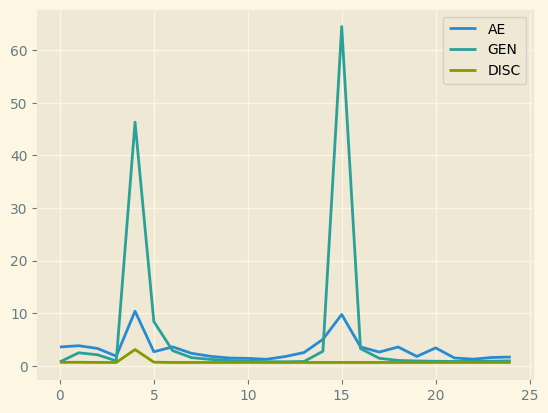

In [100]:
# plt.plot(test_cost_avg, label="test")
# plt.plot(train_cost_avg, label="train")
# plt.plot(validation_cost_avg, label="val")
# plt.legend()
# plt.show()

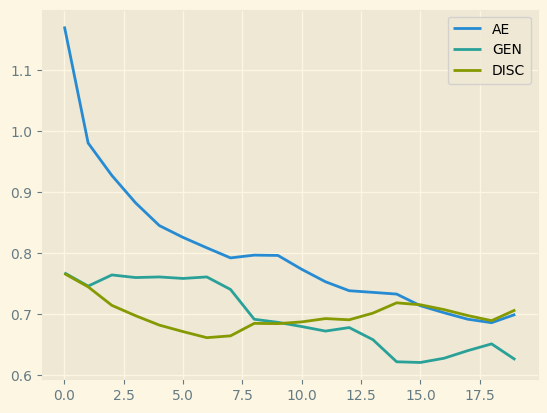

In [55]:
# Losses during training
plt.plot(train_autoencoder_loss, label="AE")
plt.plot(train_generator_loss, label="GEN")
plt.plot(train_discriminator_loss, label="DISC")
plt.legend()
plt.show()

## Investigation & Evaluation

In [58]:
# some results with average reconstruction cost
p_train = model_ae.predict(data_train)
difference_train = np.abs(p_train - data_train)
cost_train = np.mean(np.abs(p_train - data_train), axis=1)
print(f"mean: {np.mean(difference_train)}")


p_test = model_ae.predict(data_test)
difference_test = np.abs(p_test - data_test)
cost_test = np.mean(np.abs(p_test - data_test), axis=1)
print(f"mean: {np.mean(difference_test)}")

2023-07-11 17:05:42.138183: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4383/4383 [==============================] - 183s 42ms/step
mean: 0.544943258091213
1297/1297 [==============================] - 55s 42ms/step
mean: 0.5573903051488622


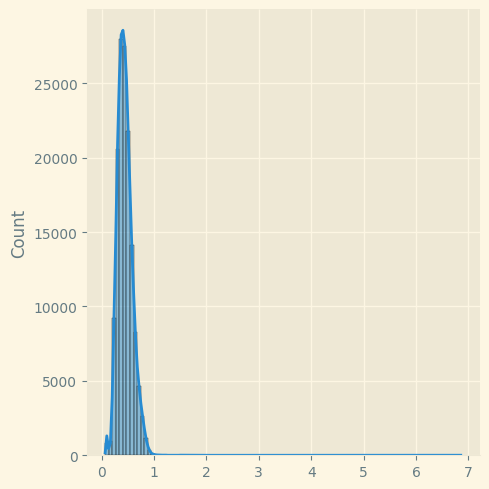

In [59]:
sns.displot(cost_train[:,32], bins=100, kde=True, label="Train")

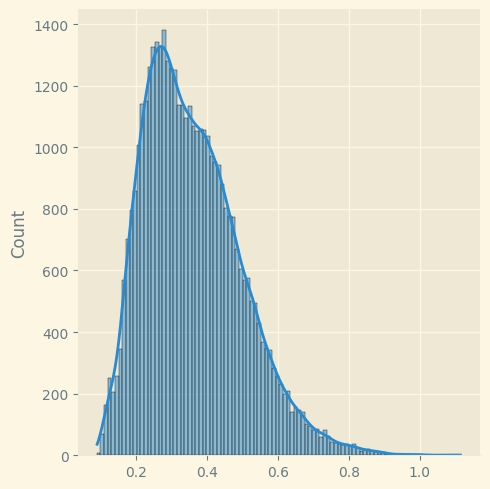

In [60]:
sns.displot(cost_test[:,32], bins=100, kde=True)

2594/2594 [==============================] - 110s 43ms/step
mean: 0.5513310817976536


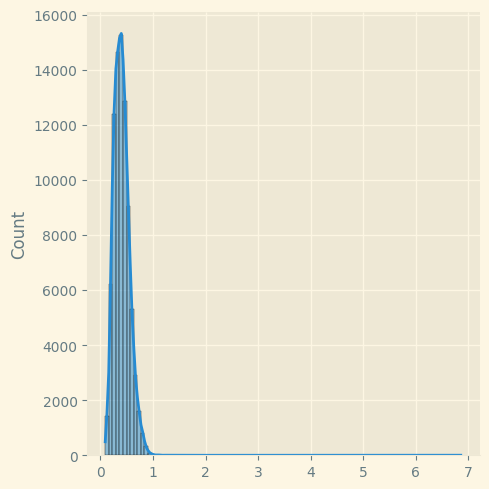

In [61]:
# Prepared test data
p_test_mixed = model_ae.predict(data_test_mixed)

difference_test_mixed = np.abs(p_test_mixed - data_test_mixed)
print(f"mean: {np.mean(difference_test_mixed)}")

cost_test_mixed = np.mean(np.abs(p_test_mixed - data_test_mixed), axis=1)
sns.displot(cost_test_mixed[:,32], bins=100, kde=True)

### PA%K

In [68]:
# PAK function to make adjustments on predictions
def pak(scores, targets, thres, k=20):
    """

    :param scores: anomaly scores (mean reconstruction cost for features)
    :param targets: target labels (1-0)
    :param thres: anomaly threshold
    :param k: PA%K ratio, 0 equals to conventional point adjust and 100 equals to original predictions
    :return: point_adjusted predictions
    """
    scores = np.array(scores)
    thres = np.array(thres)

    predicts = scores > thres
    actuals = targets > 0.01

    one_start_idx = np.where(np.diff(actuals, prepend=0) == 1)[0]
    zero_start_idx = np.where(np.diff(actuals, prepend=0) == -1)[0]

    assert len(one_start_idx) == len(zero_start_idx) + 1 or len(one_start_idx) == len(zero_start_idx)

    if len(one_start_idx) == len(zero_start_idx) + 1:
        zero_start_idx = np.append(zero_start_idx, len(predicts))

    for i in range(len(one_start_idx)):
        if predicts[one_start_idx[i]:zero_start_idx[i]].sum() > k / 100 * (zero_start_idx[i] - one_start_idx[i]):
            predicts[one_start_idx[i]:zero_start_idx[i]] = 1

    return predicts

In [69]:
# Evaluate function which gives results with comparison of with PAK function and without it
def evaluate(scores, targets, pa=True, interval=50, k=40):
    """
    :param scores: list or np.array or tensor, anomaly score
    :param targets: list or np.array or tensor, target labels
    :param pa: True/False
    :param interval: threshold search interval
    :param k: PA%K threshold
    :return: results dictionary
    """
    assert len(scores) == len(targets)

    results = {}

    try:
        scores = np.asarray(scores)
        targets = np.asarray(targets)
    except TypeError:
        scores = np.asarray(scores.cpu())
        targets = np.asarray(targets.cpu())

    precision, recall, threshold = metrics.precision_recall_curve(targets, scores)
    f1_score = 2 * precision * recall / (precision + recall + 1e-30)

    #print(f"WITHOUT PA: \nMean precision: {np.mean(precision)} \nMean recall: {np.mean(recall)} \nMean F1 score: {np.mean(f1_score)}")

    results['best_f1_wo_pa'] = np.max(f1_score)
    results['f1_scores'] = f1_score
    results['best_precision_wo_pa'] = precision[np.argmax(f1_score)]
    results['best_recall_wo_pa'] = recall[np.argmax(f1_score)]
    results['prauc_wo_pa'] = metrics.average_precision_score(targets, scores)
    try:
        results['auc_wo_pa'] = metrics.roc_auc_score(targets, scores)
    except ValueError:
        pass


    if pa:
        # find F1 score with optimal threshold of best_f1_wo_pa
        pa_scores = pak(scores, targets, threshold[np.argmax(f1_score)], k)
        results['raw_f1_w_pa'] = metrics.f1_score(targets, pa_scores)
        results['raw_precision_w_pa'] = metrics.precision_score(targets, pa_scores)
        results['raw_recall_w_pa'] = metrics.recall_score(targets, pa_scores)

        # find best F1 score with varying thresholds
        if len(scores) // interval < 1:
            ths = threshold
        else:
            ths = [threshold[interval*i] for i in range(len(threshold)//interval)]
        pa_f1_scores = [metrics.f1_score(targets, pak(scores, targets, th, k)) for th in tqdm(ths)]
        pa_f1_scores = np.asarray(pa_f1_scores)
        results['best_f1_w_pa'] = np.max(pa_f1_scores)
        results['best_f1_th_w_pa'] = ths[np.argmax(pa_f1_scores)]
        pa_scores = pak(scores, targets, ths[np.argmax(pa_f1_scores)], k)
        results['best_precision_w_pa'] = metrics.precision_score(targets, pa_scores)
        results['best_recall_w_pa'] = metrics.recall_score(targets, pa_scores)
        results['pa_f1_scores'] = pa_f1_scores

    return results

In [71]:
# For model predictions
scores = np.mean(cost_test_mixed, axis=1)
targets = label_test_mixed.ravel()

In [72]:
result = evaluate(scores, targets, k=50)

mean_f1_wo_pa = np.mean(result["f1_scores"])
mean_f1_w_pa = np.mean(result["pa_f1_scores"])
print(f"mean F1 score without PA: {mean_f1_wo_pa} \nmean F1 score with PA: {mean_f1_w_pa}")

100%|██████████| 1659/1659 [00:37<00:00, 44.65it/s]


mean F1 score without PA: 0.4721781635440042 
mean F1 score with PA: 0.5523123678925695


In [67]:
result

{'best_f1_wo_pa': 0.6681159770364823,
 'f1_scores': array([0.66666667, 0.66667202, 0.66667738, ..., 0.        , 0.        ,
        0.        ]),
 'best_precision_wo_pa': 0.5016383135647526,
 'best_recall_wo_pa': 0.9999758978067004,
 'prauc_wo_pa': 0.57936106655686,
 'auc_wo_pa': 0.5208207607195943,
 'raw_f1_w_pa': 0.6681267009130581,
 'raw_precision_w_pa': 0.5016443391207622,
 'raw_recall_w_pa': 1.0,
 'best_f1_w_pa': 0.9985920069316582,
 'best_f1_th_w_pa': 0.805729185583551,
 'best_precision_w_pa': 0.9971879731775903,
 'best_recall_w_pa': 1.0,
 'pa_f1_scores': array([6.66672023e-01, 6.66725588e-01, 6.66779163e-01, ...,
        4.33536453e-04, 3.37276253e-04, 4.81939324e-05])}